# Using ANN for European style option pricing and calibration purpose

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.random import standard_normal, seed, uniform, randint
import scipy.stats as stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(42)

##  Case of single asset BS European option

**Reminder: Black Scholes formula for european option and implied volatility**


In the Black-Scholes framework, the stock is assumed to follow a GBM Ito process as follow:

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

where $Z$ is a standard normal random variable.

The principle of portfolio replication leads to a PDE for option price :
$$\frac{ \partial V }{\partial t} + \frac{1}{2}\sigma^2 S^2\frac{ \partial V^2 }{\partial S^2} + rS\frac{ \partial V }{\partial S}-rV = 0$$ with terminal condition $$V(t=T,S) = (S_0 - k)_+$$

For European plain vanilla option, a closed form solution exists as follow for one asset:
$$V_c(t, S)= SN(d_1) - Ke^{-r(T-t)}N(d_2)$$
with : $d_1=\frac{ \log{S/K} + (r-0.5\sigma^2)(T-t) }{\sigma \sqrt{T-t}}$ and $d_2 = d_1 - \sigma \sqrt{T-t}$

**Pricing using MLP**

We will train an MLP regressor to learn the option price from B&S parameters in a supervised learning formulation 

We construct a dataset by independent random sampling of B&S parameters and then compute option price using B&S formula. We construct the variables as follow:

- Explanatory variables : init stock price/strike, time to maturity (yearly fraction), IV, risk free rate
- target variable: European call price/Strike

We then split the dataset in a train and test sample in proportion 70%-30%

1 - **Generating the datasets**

In [37]:
from pricing_utils import bs_call

n_sample = 100000
data = pd.DataFrame()
data['S0/K'] = uniform(low=0.4, high=1.6, size=n_sample)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=n_sample)
data['sigma'] = uniform(low=0.01, high=1, size=n_sample)
data['r'] = uniform(low=0.02, high=0.1, size=n_sample)
data['BS_price/K'] = bs_call(data['S0/K'].values,
                           1, data['r'].values,
                           data['sigma'].values,
                           data['to_maturity'].values)


y = data['BS_price/K']
X = data.drop(columns='BS_price/K')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)

2 - **Calibration of hyperparameters**

For tuning hyperparameters, we use Bayesian optimization implemented by Hyperopt library (tree Parzen algorithm) which is an iterative approach that store all hyperparameters tested during execution.

In [2]:
from ml_models import MLPRegressor
from ml_utils import bayesian_tuning
from sklearn.preprocessing import StandardScaler
from hyperopt import hp, tpe

Using TensorFlow backend.
C:\Users\pascal\PycharmProjects\ml_option_pricing\ml_option_pricing\ml_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [9]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}

model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=4,
    epochs=10,
    batch_size=1024,
    loss="mse",
    verbose=0
)


tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )

100%|████████████████████████████████████████████| 50/50 [52:04<00:00, 62.49s/trial, best loss: 1.8550190303562985e-05]



In [10]:
best_params = tuning_output[0]['hyperparameters']
best_params

{'activation': 'tanh',
 'batch_normalisation': False,
 'beta_1': 0.6300696431330379,
 'beta_2': 0.409710231506068,
 'dropout': 0.0018581460145205009,
 'hidden_size': 180,
 'kernel_initializer': 'normal',
 'learning_rate': 0.00015449294956219027}

3 - **Train and test**

In [11]:
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=4,
    batch_size=1024,
    epochs=50,
    loss="mse",
    verbose=1
)
model.set_params(**best_params)

model.verbose = 1
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

Epoch 1/50
67000/67000 [==============================] - 1s 16us/step - loss: 0.0282 - mse: 0.0282
Epoch 2/50
67000/67000 [==============================] - 1s 15us/step - loss: 5.4255e-04 - mse: 5.4255e-04
Epoch 3/50
67000/67000 [==============================] - 1s 20us/step - loss: 3.6788e-04 - mse: 3.6788e-04
Epoch 4/50
67000/67000 [==============================] - 1s 15us/step - loss: 2.2276e-04 - mse: 2.2276e-04
Epoch 5/50
67000/67000 [==============================] - 1s 20us/step - loss: 1.1848e-04 - mse: 1.1848e-04
Epoch 6/50
67000/67000 [==============================] - 1s 15us/step - loss: 7.9335e-05 - mse: 7.9335e-05
Epoch 7/50
67000/67000 [==============================] - 1s 20us/step - loss: 6.2411e-05 - mse: 6.2411e-05
Epoch 8/50
67000/67000 [==============================] - 1s 15us/step - loss: 5.2041e-05 - mse: 5.2041e-05
Epoch 9/50
67000/67000 [==============================] - 1s 19us/step - loss: 4.4935e-05 - mse: 4.4935e-05
Epoch 10/50
67000/67000 [===========

In [12]:
y_hat = model.predict(X_train)
starttime = time.time()
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))


Time Cost predict: 0.457775354385376 seconds
mse on train set 4.225750326652832e-06
mae on train set 0.0015665030244798922
mse on test set 1.1652354546438333e-05
mae on test set 0.0027649811296425737


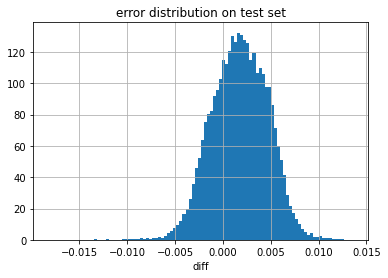

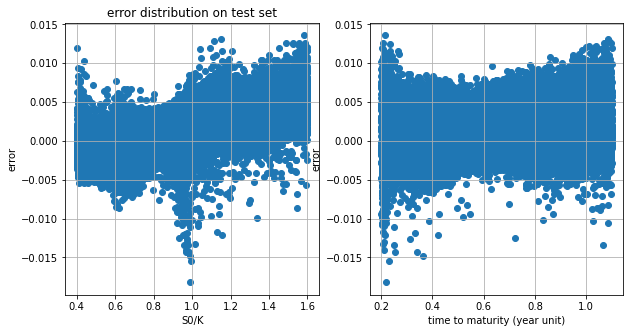

In [13]:
diff = y_test.values - y_pred.ravel()
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.xlabel('S0/K')
plt.ylabel('error')
plt.title('error distribution on test set')
dist = plt.scatter(X_test['S0/K'], diff)
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()

We observe that the error is higher close to the money and boundary of of maturity and strike

4 - **Compare with other models**

**Linear Regression**

In [32]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)


mse on test set 0.0037429366688963178
mae on test set 0.0494982581702424


**Gaussian process regression**

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train[:10000], y_train[:10000]) # train on 10 000 data point is sufficient 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)



Time Cost train: 41.37523651123047 seconds

Time Cost predict: 101.69892239570618 seconds
mse on test set 2.392997369536552e-06
mae on test set 0.0007179205725593282


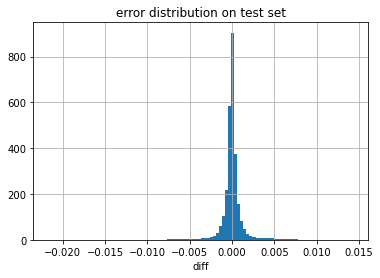

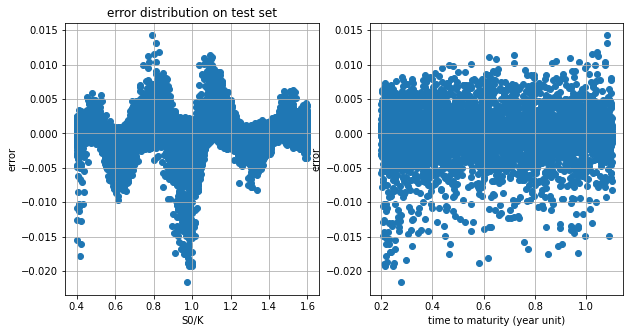

In [39]:
diff = y_test.values - y_pred.ravel()
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.xlabel('S0/K')
plt.ylabel('error')
plt.title('error distribution on test set')
dist = plt.scatter(X_test['S0/K'], diff)
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()

5 - **Implied volatility computation**

We now calibrate B&S implied volatility using MLP with observed prices, ie re-compute IV given observed market prices

We construct our dataset by generating call prices using random sampling IV and other parameters and then formulate the following supervised learning problem:

 - Explanatory variables : E call prices/strike, init stock/strike, time to maturity (yearly fraction), risk free rate
 - Target : IV 


In [ ]:
data = pd.DataFrame()
data['S0/K'] = uniform(low=0.4, high=1.6, size=10000)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=(len(data)))
data['sigma'] = uniform(low=0.01, high=1, size=len(data)) 
data['r'] = uniform(low=0.02, high=0.1, size=len(data))
data['BS_price/K'] = bs_call(data['S0/K'].values,
                           1, data['r'].values,
                           data['sigma'].values,
                           data['to_maturity'].values) # we generate price using sampled sigma 
# we take the log of option time value for gradient issue
data['log(time_value/K)'] = np.log(data['BS_price/K'] - \
                                   np.maximum(data['S0/K'] - np.exp(-data['r'] * data['to_maturity']), 0))

data = data[data['log(time_value/K)']>-1e7] # drop small values
y = data['sigma']
X = data[['S0/K', 'to_maturity', 'r', 'log(time_value/K)']]
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [21]:
model.verbose = 0
tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))

100%|████████████████████████████████████████████| 50/50 [1:02:22<00:00, 74.85s/trial, best loss: 0.024055723708364785]


Time Cost: 25.74895453453064 seconds
mse on train set 0.0020751623896354634
mae on train set 0.03527376307439293
mse on test set 0.0016923051409279738
mae on test set 0.030896452785355577


In [ ]:
from pricing_utils import bs_vol_imp_call

X = data
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)
starttime = time.time()
iv_newton = [bs_vol_imp_call(X_test.iloc[i]['S0/K'],
                          1,
                          X_test.iloc[i]['to_maturity'],
                          X_test.iloc[i]['BS_price/K'],
                          X_test.iloc[i]['r'],
                          sigma_init=1) for i in range(len(X_test))]
endtime = time.time()
iv_newton = np.array(iv_newton)
print('\nTime Cost:', endtime - starttime, 'seconds')
print('mse newton on test set', mean_squared_error(y_test, iv_newton))
print('mae newton on test set', mean_absolute_error(y_test, iv_newton))

6 - **Conclusion**

- Neural network NLP can offer better precision but need high number of sample to be efficiently trained
- Single hidden layer seems sufficient for the case of one asset
- Gaussian process can do better with small dataset but prediction is longer
- The performance can be highly deteriorated for new set of parameters that are close or out of the boundary of the training space

## Case of basket option (Multi-underlying)

**Brief presentation:**

We consider a basket call option on an index $I_t$ given by :
$$I_t = a_1S^1_t + ... + a_dS^d_t$$
where $a_i>0$,  $\sum a_i = 1$ and where each of the d assets follow a GBM:

$dS^i_t=r S^i_tdt+\sigma_i S^i_tdW^i_t\quad\quad$ with $\quad d \langle W^i, W^j\rangle_t = \rho_{ij}dt\quad$ and $\quad \rho_{ij}=\frac{\sum^{d}_{k=1}{\Sigma_{ik}\Sigma_{jk}}}{\sigma_i \sigma_j}$

Under risk-neutral measure

We consider payoff of kind $(I_T - K)_+$

**Monte-Carlo Pricing**

The Feynman-Kac theorem enable to write the option price as the conditional expectation of the discounted terminal payoff under the risk neutral measure and thus we will use Monte-Carlo simulation of stock path to estimate this value. A very basic MC pricer is used, no variance reduction technics

1 - **Generating dataset for 4 assets**

In [40]:
from scipy.stats import random_correlation
from pricing_utils import payoff_call_basket, basket_mc_price

n_sample = 10000
d = 4
N = 10000 #nb path for pricer
data_sample = []
data = []
starttime = time.time()

for n in range(n_sample):
    Rho = random_correlation.rvs((.5, .8, 1.2, 1.5)) 
    sigma = uniform(low=0.01, high=1, size=d)
    Gamma = np.diag(sigma) * Rho * np.diag(sigma)
    Sigma=np.sqrt(Gamma)
    r = uniform(low=0.02, high=0.1)
    T = uniform(low=0.2, high=1.1) # annualized
    a = (1/d)*np.ones(d) # fixed weights 
    S_0 = np.random.lognormal(mean=0.5, sigma=0.25, size=4)
    I_0 = np.dot(a, S_0)
    K = uniform(low=1, high=3) 
    Call_price, _, _ = basket_mc_price(N, S_0/K, 1, r, T, sigma, Sigma, a, fonction_payoff=payoff_call_basket)
    data_sample = np.concatenate([Rho[0,1:], Rho[1,2:], Rho[2,3:], sigma, S_0/K,  [r, T, Call_price]])
    data.append(data_sample)

endtime = time.time()
print('\nTime Cost of MC pricing: ~', (endtime - starttime) * 0.33, 'seconds')

data = pd.DataFrame(data,
                   columns=['rho_12', 'rho_13', 'rho_14','rho_23', 'rho_24', 'rho_34',
                           'sigma_1', 'sigma_2', 'sigma_3', 'sigma_4', 'S1_0/K', 'S2_0/K',
                            'S3_0/K', 'S4_0/K', 'r', 'T', 'Price'])
y = data['Price']
X = data.drop(columns='Price')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Time Cost of MC pricing: ~ 11.901693291664124 seconds


2 - **MLP pricing**

In [26]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}

model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=16,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)

tuning_output = bayesian_tuning(
           X_train.values,
           y_train.values,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
print('best_params:')
print(best_params)

100%|████████████████████████████████████████████| 50/50 [10:54<00:00, 13.09s/trial, best loss: 0.00012880593383592098]

best_params:
{'activation': 'relu', 'batch_normalisation': False, 'beta_1': 0.5376808511121938, 'beta_2': 0.6724216233003347, 'dropout': 0.011986471818406869, 'hidden_size': 160, 'hidden_size_2': 100, 'kernel_initializer': 'normal', 'learning_rate': 0.00016999986607110835}


In [42]:
model.epochs=100
model.batch_size=1024
model.set_params(**best_params)

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
starttime = time.time()
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))


Time Cost training: 10.102301359176636 seconds

Time Cost predict: 0.08976364135742188 seconds
mse on train set 2.7387665524908807e-05
mae on train set 0.003823132944112368
mse on test set 4.780324122413507e-05
mae on test set 0.004878958994490042


Error distribution

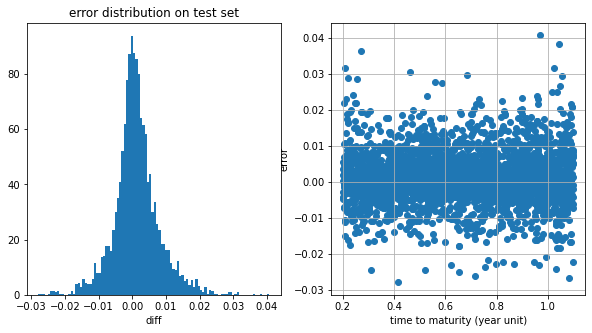

In [44]:
diff = y_test.values - y_pred.ravel()

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()
plt.grid()
bx = plt.subplot(122)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['T'], diff)
plt.grid()

3 - **Gaussian Process pricing**

In [29]:
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train, y_train) 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)


Time Cost train: 10.64850902557373 seconds

Time Cost predict: 1.2297098636627197 seconds
mse on test set 0.0002573993882746857
mae on test set 0.004581358782621973


6 - **Conclusion**

In this case with more features, using two hidden layers for MLP leads to better performance

## Case of stochastic vol framework

**Model**



The Heston Model is defined as follow (under risk-neutral measure):
$$dS_t=r S_tdt+ \sqrt{v_t} S_tdW^S_t$$
$$dv_t=\kappa (v - v_t)dt+\gamma \sqrt{v_t}dW^v_t$$

$d \langle W^S, W^v\rangle_t = \rho_{Sv}dt\quad$, $\quad S_{t_0}=S_0$, $\quad v_{t_0}=v_0$

Note that we have more than one source of uncertaincy (volatility term parameters) and thus leads to non uniqueness of a risk-neutral price.

**Pricer**

We use here an implementation of the COS method to compute call prices for our study

1 - **Generating dataset**

In [45]:
from pricing_utils import cos_heston_price

n_sample = 100000
data = pd.DataFrame()
data['S_0/K'] = uniform(low=0.4, high=1.6, size=n_sample)
data['to_maturity'] = uniform(low=0.2, high=1.1, size=n_sample)
data['r'] = uniform(low=0.02, high=0.1, size=n_sample)
data['init_variance'] = uniform(low=0.05, high=1, size=n_sample)
data['mean_variance'] = uniform(low=0.01, high=1, size=n_sample)
data['reversion_speed'] = uniform(low=0.01, high=3, size=n_sample)
data['gamma'] = uniform(low=0.01, high=0.8, size=n_sample)
data['rho'] = uniform(low=-0.9, high=0, size=n_sample)
starttime = time.time()
data['call_price'] = [cos_heston_price(data.iloc[i]['S_0/K'],
                                       1,
                                       data.iloc[i]['r'],
                                       data.iloc[i]['to_maturity'],
                                       data.iloc[i]['mean_variance'],
                                       data.iloc[i]['init_variance'],
                                       data.iloc[i]['reversion_speed'],
                                       data.iloc[i]['gamma'],
                                       data.iloc[i]['rho'],
                                       call=True)
                      for i in range(len(data))]
endtime = time.time()
print('\nTime Cost pricing: ~', (endtime - starttime)/3, 'seconds')

data = data[(data['call_price']>0) & (data['call_price']<1)] #drop extrem values
y = data['call_price']
X = data.drop(columns='call_price')
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.33, random_state=42)


Time Cost pricing: ~ 112.49125830332439 seconds


Text(0.5, 1.0, 'call price distribution')

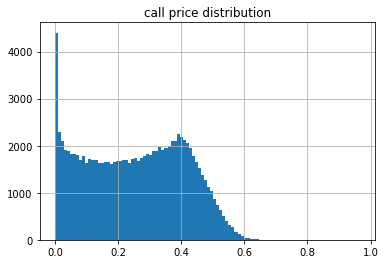

In [35]:
data['call_price'].hist(bins=100)
plt.title('call price distribution')

2 - **Pricing with MLP**

In [29]:
param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(20, 400, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(20, 400, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.5),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=8,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = calibration(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=50,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']

100%|█████████████████████████████████████████| 50/50 [2:24:00<00:00, 172.80s/trial, best loss: 0.00016664903476740155]



In [47]:
model.epochs=100
model.batch_size=1024
model.set_params(**best_params)
print('hyperparamers used')
print(best_params)

starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')

y_hat = model.predict(X_train)
y_pred = model.predict(X_test) # nb_path=100 to use Monte-Carlo dropout mean
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mae on train set', mean_absolute_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('mae on test set', mean_absolute_error(y_test, y_pred))

hyperparamers used
{'activation': 'sigmoid', 'batch_normalisation': False, 'beta_1': 0.7239479308172907, 'beta_2': 0.4658923447178774, 'dropout': 0.3145559749735203, 'hidden_size': 240, 'hidden_size_2': 80, 'kernel_initializer': 'uniform', 'learning_rate': 0.0006158306591303526}

Time Cost training: 136.56036972999573 seconds
mse on train set 0.00012025746650963547
mae on train set 0.0036613856714399077
mse on test set 0.00011036520697960599
mae on test set 0.0036079036353207695


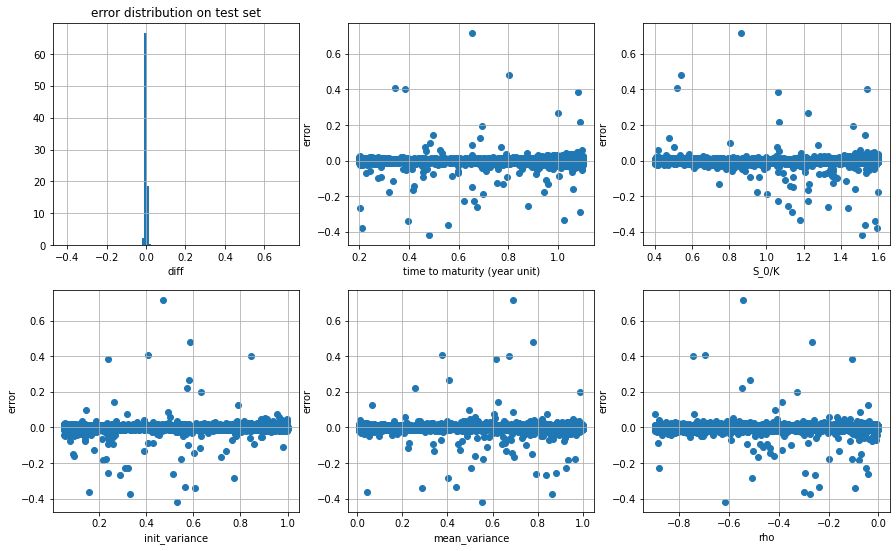

In [51]:
diff = y_test.values - y_pred.ravel()

fig = plt.figure(figsize=(15, 9))
plt.subplot(231)
plt.hist(diff, bins=100, density=True)
plt.xlabel('diff')
plt.title('error distribution on test set')
plt.grid()
plt.subplot(232)
plt.xlabel('time to maturity (year unit)')
plt.ylabel('error')
dist = plt.scatter(X_test['to_maturity'], diff)
plt.grid()
plt.subplot(233)
plt.xlabel('S_0/K')
plt.ylabel('error')
dist = plt.scatter(X_test['S_0/K'], diff)
plt.grid()
plt.subplot(234)
plt.xlabel('init_variance')
plt.ylabel('error')
dist = plt.scatter(X_test['init_variance'], diff)
plt.grid()
plt.subplot(235)
plt.xlabel('mean_variance')
plt.ylabel('error')
dist = plt.scatter(X_test['mean_variance'], diff)
plt.grid()
plt.subplot(236)
plt.xlabel('rho')
plt.ylabel('error')
dist = plt.scatter(X_test['rho'], diff)
plt.grid()

2 - **Calibration of Heston parameters with multi-output regression MLP**

An important issue with such incomplete model is to find the Heston paramters that "reflect" the observable liquid option price on market.
Fixing some value such as $K$, $T$ and $r$, and given a range of observed option prices for different init stock price ($S_0$) and init variance ($v_0$) as explanatory variables, is it possible to train a supervise ANN able to predict $(\kappa,v,\gamma, \rho)$ ? And the same but using observed prices of different $T$ for a given init price $S_0$ and init $v_0$

**Generate data**

In [6]:
from pricing_utils import cos_heston_price

#fix some parameters
K = 100
T = 1
r = 0.1

n_sample = 10000

x_data = np.zeros((n_sample, 10, 10)) # grid of 10x10 different prices
y_data = np.zeros((n_sample, 4))

#first define a space of S_0, v_0 values in which we will sample 10x10 values
init_price = 100 * uniform(low=0.4, high=1.6, size=15)
init_var = uniform(low=0.05, high=1, size=15)

mean_variance = uniform(low=0.01, high=1, size=n_sample)
reversion_speed = uniform(low=0.01, high=3, size=n_sample)
gamma = uniform(low=0.01, high=0.8, size=n_sample)
rho = uniform(low=-0.9, high=0, size=n_sample)

for i in range(n_sample):
    S_0 = np.random.choice(init_price, replace=False, size=10)
    v_0 = np.random.choice(init_var, replace=False, size=10)
    y_data[i,:] = np.array([reversion_speed[i], mean_variance[i], gamma[i], rho[i]])
    x_data[i,::] = np.array([[cos_heston_price(S_0[j], K, r, T,
                                               mean_variance[i],
                                               v_0[k],
                                               reversion_speed[i],
                                               gamma[i],
                                               rho[i],
                                               call=True)
                              for j in range(S_0.shape[0])]
                             for k in range(v_0.shape[0])])
x_data = np.where(x_data>1, 1, x_data)
x_data = np.where(x_data<0, 0, x_data)

**CNN multi-Regression**

In [8]:
from ml_models import CNNRegressor

X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
X_train = X_train.reshape(X_train.shape[0], 10,10, 1)
X_test = X_test.reshape(X_test.shape[0], 10,10, 1)

param_grid = {
    'learning_rate': hp.loguniform('learning_rate',np.log(1.), np.log(100)),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(500, 1000, 20)]),

}
model = CNNRegressor(
    input_shape=(10,10,1),
    n_output=4,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = bayesian_tuning(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=30,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
model.epochs = 100
print('hyperparameters used:')
print(best_params)
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))


100%|████████████████████████████████████████████████| 30/30 [02:57<00:00,  5.93s/trial, best loss: 0.1711858871057353]

hyperparameters used:
{'activation': 'relu', 'hidden_size': 894, 'learning_rate': 2.170582524678732}

Time Cost training: 12.529718399047852 seconds
mse on train set 0.2357965956244129
mse on test set 0.2359220904850561


**MLP multi-Regression**

In [9]:
X_train, X_test, y_train,  y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1,X_test.shape[1] * X_test.shape[2])

param_grid = {
    'batch_normalisation': hp.choice('batch_normalisation', [True, False]),
    'hidden_size': hp.choice('hidden_size',[int(x) for x in np.linspace(300, 1000, 20)]),
    'hidden_size_2': hp.choice('hidden_size_2',[None] + [int(x) for x in np.linspace(50, 500, 20)]),
    'activation': hp.choice('activation',['relu', 'tanh', 'linear', 'sigmoid' ]),
    'dropout':  hp.uniform('dropout', 0., 0.3),
    'learning_rate': hp.loguniform('learning_rate',np.log(0.0001), np.log(0.001)),
    'kernel_initializer': hp.choice('kernel_initializer', ['glorot_uniform', 'normal', 'uniform']),
    'beta_1': hp.uniform('beta_1', 0., 0.99),
    'beta_2': hp.uniform('beta_2', 0., 0.99),
}
model = MLPRegressor(
    scaler=StandardScaler(),
    n_feature=100,
    n_output=4,
    epochs=10,
    batch_size=200,
    loss="mse",
    verbose=0
)
tuning_output = bayesian_tuning(
           X_train,
           y_train,
           model=model,
           param_grid=param_grid, 
           loss_metric='mse',
           n_kfold=5,
           nb_evals=30,       
           optimizer=tpe.suggest
    )
best_params = tuning_output[0]['hyperparameters']
model.epochs = 100
print('hyperparameters used:')
print(best_params)
model.set_params(**best_params)
starttime = time.time()
model.fit(X_train, y_train)
endtime = time.time()
print('\nTime Cost training:', endtime - starttime, 'seconds')
y_hat = model.predict(X_train)
y_pred = model.predict(X_test)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))


100%|███████████████████████████████████████████████| 30/30 [27:31<00:00, 55.05s/trial, best loss: 0.06246033119474067]

hyperparameters used:
{'activation': 'sigmoid', 'batch_normalisation': False, 'beta_1': 0.9279104560589684, 'beta_2': 0.9231968462661895, 'dropout': 0.02386329410273856, 'hidden_size': 778, 'hidden_size_2': 168, 'kernel_initializer': 'glorot_uniform', 'learning_rate': 0.0009995539231962155}

Time Cost training: 107.16726565361023 seconds
mse on train set 0.010390291554666132
mse on test set 0.08825610289141314


In [10]:
error = pd.DataFrame(mean_absolute_error(y_test, y_pred, multioutput = 'raw_values')).T
error_perc = np.mean(np.divide(np.abs(y_test - y_pred), y_test)*100, axis=0)
error_perc = pd.DataFrame(error_perc).T
error = pd.concat([error, error_perc], axis=0)
error.rename(columns={0:'kappa', 1:'v_mean', 2:'gamma', 3:'rho'}, inplace=True)
error.set_index(np.array(['mae', 'mae%']), inplace=True)
print('abs error for each parameters:')
error

abs error for each parameters:


,kappa,v_mean,gamma,rho
mae,0.287787,0.164567,0.222601,0.257717
mae%,41.125478,88.786276,156.688906,-342.512047


**Use of Monte-Carlo Dropout**

In [18]:
y_pred, std, conf_inf, conf_sup = model.predict(X_test, nb_path=1000)
print('mse on train set', mean_squared_error(y_train, y_hat))
print('mse on test set', mean_squared_error(y_test, y_pred))
print('MLP Monte-Carlo Dropout mean variance:', 'kappa: {}'.format(std[0,:].mean()),
      'v: {}'.format(std[1,:].mean()), 'gamma: {}'.format(std[2,:].mean()) )

mse on train set 0.010390291554666132
mse on test set 0.08774080312325341
MLP Monte-Carlo Dropout mean variance: kappa: 0.05968843400478363 v: 0.04675784334540367 gamma: 0.05713067203760147


**Gaussian Process**

In [25]:
from sklearn.gaussian_process import GaussianProcessRegressor
reg = GaussianProcessRegressor()
starttime = time.time()
reg.fit(X_train, y_train) # train on 10 000 data point is sufficient 
endtime = time.time()
print('\nTime Cost train:', endtime - starttime, 'seconds')

starttime = time.time()
y_pred = reg.predict(X_test)
endtime = time.time()
print('\nTime Cost predict:', endtime - starttime, 'seconds')
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
print('mse on test set', mse_test)
print('mae on test set', mae_test)


Time Cost train: 14.726619482040405 seconds

Time Cost predict: 3.8267621994018555 seconds
mse on test set 0.16011469581323856
mae on test set 0.3018467168558491
